## Figures - ala2

In [3]:
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import trange

In [4]:
#set bigger font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16

plt.rc('font', size=SMALL_SIZE)        # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)   # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)   # fontsize of the figure title

In [5]:
#set palette
import fessa
plt.set_cmap('fessa')

<Figure size 432x288 with 0 Axes>

In [6]:
import bgmol
import mdtraj as md
import nglview as nv
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

In [7]:
# ala2
highT = 1000
lowT = 300
# system_name = 'AlanineDipeptideImplicit'
system_name = 'AlanineDipeptideVacuum'
model = bgmol.system_by_name(system_name)

view = nv.show_mdtraj(md.Trajectory(model.positions, model.mdtraj_topology))
view.clear_representations()
view.add_licorice()
view

NGLWidget()

In [8]:
# view.download_image(filename='ala2.png', trim=True, transparent=True)

## Prepare data

In [9]:
#load data
filename = f'../LREX-def/{system_name}-T{lowT}-traj'
prior_data = np.load(filename + '.npz')['highT']
target_data = np.load(filename + '.npz')['lowT']
mapped_data = np.load(filename + 'Mapped.npz')['data']
logw = np.load(filename + 'Mapped.npz')['logw']

#calculate energies (all with target energy!)
import torch

def calc_ene(data, temp=lowT, model=model):
    model.reinitialize_energy_model(temperature=temp)
    return model.energy(torch.as_tensor(data).view(len(data),-1)).view(-1).cpu().numpy() * (kB*temp)

print('prior ener')
prior_ener = calc_ene(prior_data)
print('target ener')
target_ener = calc_ene(target_data)
print('mapped ener')
mapped_ener = calc_ene(mapped_data)

prior ener


/srv/data/minvernizzi/programs/bgflow/bgflow/distribution/energy/openmm.py:200: UserWarning: It looks like you are using an OpenMMBridge with multiple workers in an ipython environment. This can behave a bit silly upon KeyboardInterrupt (e.g., kill the stdout stream). If you experience any issues, consider initializing the bridge with n_workers=1 in ipython/jupyter.
  warnings.warn(


target ener
mapped ener


In [10]:
%%time
#calculate ene FES
from scipy.stats import gaussian_kde

ener_grid = np.linspace(-100, 200, 300)

prior_ener_fes = gaussian_kde(prior_ener).pdf(ener_grid)
target_ener_fes = gaussian_kde(target_ener).pdf(ener_grid)
mapped_ener_fes = gaussian_kde(mapped_ener[mapped_ener<ener_grid[-1]]).pdf(ener_grid)


CPU times: user 2.54 s, sys: 549 ms, total: 3.09 s
Wall time: 1.81 s


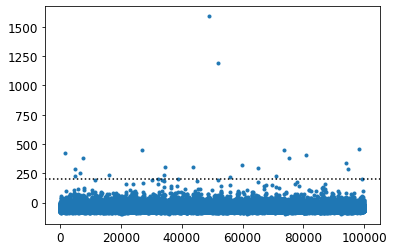

In [11]:
plt.plot(mapped_ener,'.')
# plt.plot(mapped_ener[mapped_ener<ener_grid[-1]],'.')
plt.axhline(ener_grid[-1], c='k', ls=':')
plt.show()

In [12]:
%%time
#calculate phi FES
from calcFES import calcFES

def get_phi_psi(trajectory, i=-1, model=model):
        if not isinstance(trajectory, md.Trajectory):
            # if isinstance(trajectory, torch.Tensor):
            #     trajectory = assert_numpy(trajectory.view(len(trajectory), *model.positions.shape))
            trajectory = md.Trajectory(trajectory, model.mdtraj_topology)
        phi = md.compute_phi(trajectory)[1][:,i]
        psi = md.compute_psi(trajectory)[1][:,i]
        return phi, psi

fes_grid, prior_fes = np.loadtxt(f'../FESreference/FES{highT}-{system_name}.dat', unpack=True, usecols=(0,1))
fes_grid_t, target_fes = np.loadtxt(f'../FESreference/FES{lowT}-{system_name}.dat', unpack=True, usecols=(0,1))
assert np.isclose(fes_grid, fes_grid_t).all()
fes_grid = np.append(fes_grid, np.pi)
prior_fes = np.append(prior_fes, prior_fes[0]) / (kB*highT)
target_fes = np.append(target_fes, target_fes[0]) / (kB*lowT)

bw = 0.05
mapped_fes = calcFES(fes_grid, bw, get_phi_psi(mapped_data)[0], periodic=True)
reweight_fes = calcFES(fes_grid, bw, get_phi_psi(mapped_data)[0], logw, periodic=True)

CPU times: user 684 ms, sys: 14.6 ms, total: 699 ms
Wall time: 706 ms


In [13]:
import bgflow as bg

z_matrix = bgmol.ZMatrixFactory(model.mdtraj_topology).build_with_templates()[0]
coordinate_transform = bg.GlobalInternalCoordinateTransformation(z_matrix)

def get_IC(data, l, i):
    with torch.no_grad():
        ic = coordinate_transform.forward(torch.as_tensor(data, dtype=torch.float32).view(len(data),-1))[l][:,i].cpu().numpy()
    if l == 1:
        return np.pi * ic
    elif l == 2:
        return 2 * np.pi * (ic - 0.5)
    else:
        return ic

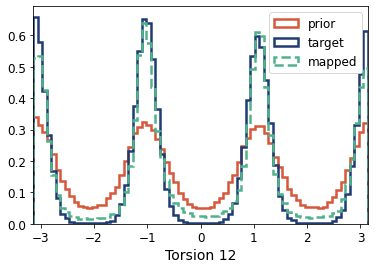

CPU times: user 10.2 s, sys: 635 ms, total: 10.8 s
Wall time: 2.73 s


In [14]:
%%time

l = 2
i = 12
ic_type = ['Bond', 'Angle', 'Torsion']
prior_ic = get_IC(prior_data, l, i)
grid = np.linspace(prior_ic.min(), prior_ic.max(), 75)
hist_opt = {'bins': grid, 'density': True, 'histtype': 'step', 'lw': 2.5}

plt.hist(prior_ic, **hist_opt, label='prior', color='fessa6')
target_ic = get_IC(target_data, l, i)
plt.hist(target_ic, **hist_opt, label='target', color='fessa0')
mapped_ic = get_IC(mapped_data, l, i)
plt.hist(mapped_ic, **hist_opt, label='mapped', color='fessa2', ls='--')
# plt.hist(mapped_ic, **hist_opt, label='rew', weights=np.exp(logw), color='fessa2', ls=':')

plt.xlim(grid[0], grid[-1])
plt.xlabel(f'{ic_type[l]} {i}')
plt.legend()
plt.show()

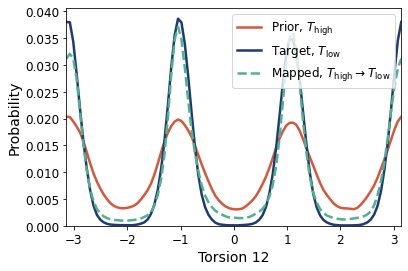

In [15]:
labels = ['Prior, $T_{\mathrm{high}}$', r'Mapped, $T_{\mathrm{high}} \rightarrow T_{\mathrm{low}}$', 'Mapped and Reweighted', 'Target, $T_{\mathrm{low}}$']

periodic = False
if l == 1:
    grid = np.linspace(0, np.pi, 100)
elif l == 2:
    periodic = True
    grid = np.linspace(-np.pi, np.pi, 100)
else:
    grid = np.linspace(prior_ic.min(), prior_ic.max(), 100)
bw = (grid[-1]-grid[0])/100

prior_ic_fes = calcFES(grid, bw, prior_ic, periodic=periodic)
target_ic_fes = calcFES(grid, bw, target_ic, periodic=periodic)
mapped_ic_fes = calcFES(grid, bw, mapped_ic, periodic=periodic)
reweighted_ic_fes = calcFES(grid, bw, mapped_ic, periodic=periodic, logweights=logw)

lw = 2.5
# plt.plot(grid, prior_ic_fes,      lw=lw, label='prior',  c='fessa6')
# plt.plot(grid, target_ic_fes,     lw=lw, label='target', c='fessa0')
# plt.plot(grid, mapped_ic_fes,     lw=lw, label='mapped', c='fessa2', ls='--')
# plt.plot(grid, reweighted_ic_fes, lw=lw, label='reweighted', c='fessa2', ls=':')

plt.plot(grid, np.exp(-prior_ic_fes-np.logaddexp.reduce(-prior_ic_fes)),  lw=lw, label=labels[0], c='fessa6')
plt.plot(grid, np.exp(-target_ic_fes-np.logaddexp.reduce(-target_ic_fes)), lw=lw, label=labels[-1], c='fessa0')
# plt.plot(fes_grid, np.exp(-target_fes-np.logaddexp.reduce(-target_fes)), lw=lw, label='target2', c='fessa4', ls='--')
plt.plot(grid, np.exp(-mapped_ic_fes-np.logaddexp.reduce(-mapped_ic_fes)), lw=lw, label=labels[1], c='fessa2', ls='--')
# plt.plot(grid, np.exp(-reweighted_ic_fes-np.logaddexp.reduce(-reweighted_ic_fes)), lw=lw, label=labels[2], c='fessa2', ls=':')

plt.xlim(grid[0], grid[-1])
plt.ylim(0, None)
plt.xlabel(f'{ic_type[l]} {i}')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [16]:
labels = ['Prior, $T_{\mathrm{high}}$', r'Mapped, $T_{\mathrm{high}} \rightarrow T_{\mathrm{low}}$', 'Mapped and Reweighted', 'Target, $T_{\mathrm{low}}$']
ic_type = ['Bond', 'Angle', 'Torsion']

def plot_marginals(ax, l, i, reweighted=False):
    prior_ic = get_IC(prior_data, l, i)
    target_ic = get_IC(target_data, l, i)
    mapped_ic = get_IC(mapped_data, l, i)
    
    periodic = True if l == 2 else False
    unit = ' [nm]' if l == 0 else ' [rad]'
    grid = np.linspace(prior_ic.min(), prior_ic.max(), 100)
    
    # periodic = False
    # unit = ' [rad]'
    # if l == 1:
    #     grid = np.linspace(0, np.pi, 100)
    #     ax.set_xticks([0, np.pi/2, np.pi], ['0','$\pi/2$','$\pi$'])
    # elif l == 2:
    #     periodic = True
    #     grid = np.linspace(-np.pi, np.pi, 100)
    #     ax.set_xticks([-np.pi/2, 0, np.pi/2], ['$-\pi/2$','0','$\pi/2$'])
    # else:
    #     grid = np.linspace(prior_ic.min(), prior_ic.max(), 100)
    #     unit = ' [nm]'
    bw = (grid[-1]-grid[0])/100
    
    prior_ic_fes = calcFES(grid, bw, prior_ic, periodic=periodic)
    target_ic_fes = calcFES(grid, bw, target_ic, periodic=periodic)
    mapped_ic_fes = calcFES(grid, bw, mapped_ic, periodic=periodic)
    if reweighted:
        reweighted_ic_fes = calcFES(grid, bw, mapped_ic, periodic=periodic, logweights=logw)
    
    lw = 2.5
    ax.plot(grid, np.exp(-prior_ic_fes-np.logaddexp.reduce(-prior_ic_fes)),  lw=lw, label=labels[0], c='fessa6')
    ax.plot(grid, np.exp(-target_ic_fes-np.logaddexp.reduce(-target_ic_fes)), lw=lw, label=labels[-1], c='fessa0')
    ax.plot(grid, np.exp(-mapped_ic_fes-np.logaddexp.reduce(-mapped_ic_fes)), lw=lw, label=labels[1], c='fessa2', ls='--')
    if reweighted:
        ax.plot(grid, np.exp(-reweighted_ic_fes-np.logaddexp.reduce(-reweighted_ic_fes)), lw=lw, label=labels[2], c='fessa2', ls=':')

    ax.set_xlim(grid[0], grid[-1])
    ax.set_ylim(0, None)
    ax.set_xlabel(f'{ic_type[l]}{i}{unit}')
    # ax.set_ylabel('Probability')
    ax.set_yticklabels([])
    # ax.set_box_aspect(0.6)

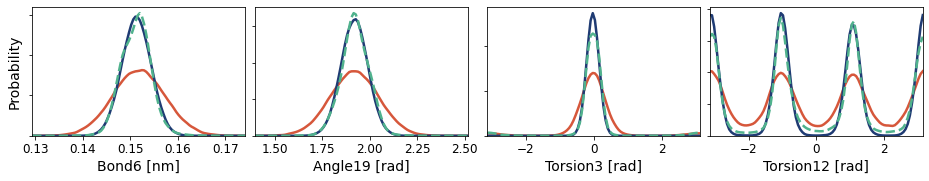

CPU times: user 47.7 s, sys: 783 ms, total: 48.5 s
Wall time: 14.7 s


In [17]:
%%time
fig = plt.figure(figsize=(2*6.4, 0.5*4.8), layout="constrained")
gs = fig.add_gridspec(1, 4)
axs = gs.subplots()

print('1...', end='\r')
plot_marginals(axs[0], 0, 6)
axs[0].set_ylabel('Probability')
print('2...', end='\r')
plot_marginals(axs[1], 1, 19)
print('3...', end='\r')
plot_marginals(axs[2], 2, 3)
print('4...', end='\r')
plot_marginals(axs[3], 2, 12)

plt.show()

## Plotting

In [18]:
# some plotting functions
from matplotlib.colors import LogNorm

plot_range = (-np.pi, np.pi)
ticks = [-np.pi/2, 0, np.pi/2], ['$-\pi/2$','0','$\pi/2$']
def plot_rama(ax, phi, psi, label=None, w=None, bins=75, vmax=6, no_y=True):
    if label is not None:
        ax.set_title(label)
    grid = np.linspace(*plot_range, bins)
    hist, *_ = np.histogram2d(phi, psi, bins=(grid, grid), weights=w)
    fes = -np.log(np.where(hist!=0, hist / hist.max(), np.nan)).T
    ct = ax.pcolormesh(*np.meshgrid(grid, grid), fes, vmax=vmax, rasterized=True)
    ax.set_xlim(plot_range)
    ax.set_ylim(plot_range)
    ax.set_xlabel("$\phi$")
    ax.set_xticks(*ticks)
    if no_y:
        ax.set_ylabel('')
        ax.set_yticks(ticks[0],['']*3)
    else:
        ax.set_ylabel("$\psi$", labelpad=-5)
        ax.set_yticks(*ticks)
    ax.set_box_aspect(1)
    return ct

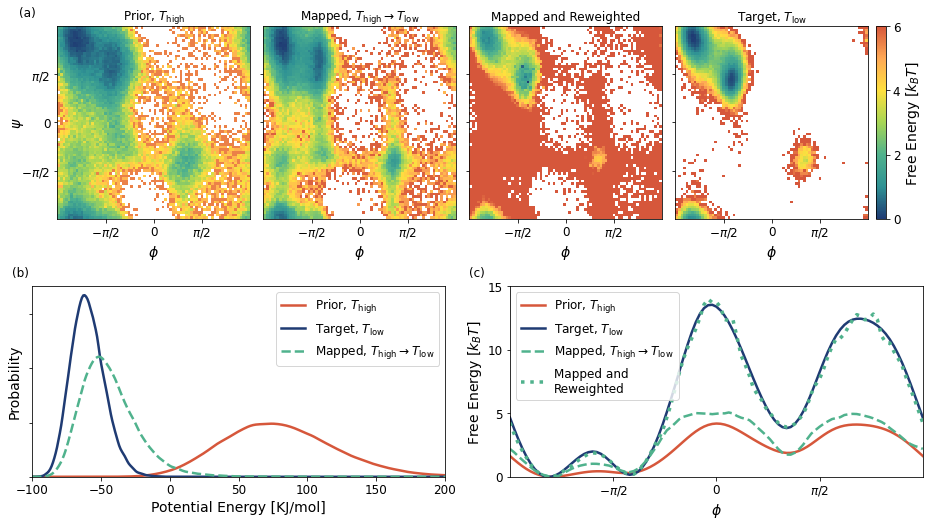

In [19]:
labels = ['Prior, $T_{\mathrm{high}}$', r'Mapped, $T_{\mathrm{high}} \rightarrow T_{\mathrm{low}}$', 'Mapped and Reweighted', 'Target, $T_{\mathrm{low}}$']

fig = plt.figure(figsize=(2*6.4, 1.5*4.8), layout="constrained")
gs = fig.add_gridspec(2, 1)
gs_up = gs[0].subgridspec(1, 4)
gs_down = gs[1].subgridspec(1, 2)

#upper half
axs = gs_up.subplots()#sharex=True, sharey=True)
axs[0].text(-0.2, 1.05, '(a)', transform=axs[0].transAxes, fontdict={'size': 12})

ax = axs[0]
ax.set_title(labels[0])
plot_rama(ax, *get_phi_psi(prior_data), no_y=False)

ax = axs[1]
ax.set_title(labels[1])
plot_rama(ax, *get_phi_psi(mapped_data), no_y=True)

ax = axs[2]
ax.set_title(labels[2])
plot_rama(ax, *get_phi_psi(mapped_data), w=np.exp(logw), no_y=True)

ax = axs[3]
ax.set_title(labels[3])
ct = plot_rama(ax, *get_phi_psi(target_data), no_y=True)

cb = plt.colorbar(ct, ax=axs, ticks=np.arange(0,7,2), pad=0.01, fraction=0.012)
cb.set_label('Free Energy [$k_BT$]')

#lower half
axs = gs_down.subplots(sharex=False, sharey=False)

# energies
lw = 2.5
ax = axs[0]
ax.text(-0.05, 1.05, '(b)', transform=ax.transAxes, fontdict={'size': 12})

ax.plot(ener_grid, prior_ener_fes, color=f'fessa6', label=labels[0], lw=lw)
ax.plot(ener_grid, target_ener_fes, color=f'fessa0', label=labels[-1], lw=lw)
ax.plot(ener_grid, mapped_ener_fes, color=f'fessa2', label=labels[1], lw=lw, ls='--')

ax.set_xlim(ener_grid[0], ener_grid[-1])
ax.set_ylim(0, None)
ax.set_xlabel('Potential Energy [KJ/mol]')
ax.set_ylabel('Probability')
ax.set_yticklabels([])
ax.legend()

# phi FES
ax = axs[1]
ax.text(-0.1, 1.05, '(c)', transform=ax.transAxes, fontdict={'size': 12})

ax.plot(fes_grid, prior_fes, c='fessa6', lw=lw, label=labels[0])
ax.plot(fes_grid, target_fes, c='fessa0', lw=lw, label=labels[-1])
ax.plot(fes_grid, mapped_fes, c='fessa2', lw=lw, ls='--', label=labels[1])
my_str = labels[2]
labels[2] = my_str[:my_str.index('Rew')] + '\n' + my_str[my_str.index('Rew'):]
ax.plot(fes_grid, reweight_fes, c='fessa2', lw=lw+1, ls=':', label=labels[2])

ax.set_xlim(-np.pi, np.pi)
ax.set_xticks(*ticks)
ax.set_xlabel('$\phi$')
ax.set_ylim(0, 15)
ax.set_yticks(np.arange(0,20,5))
ax.set_ylabel('Free Energy [$k_BT$]')
ax.legend()

# fig.suptitle('Alanine Dipeptide')
plt.savefig('Ala2-all.pdf', bbox_inches='tight')
plt.show()

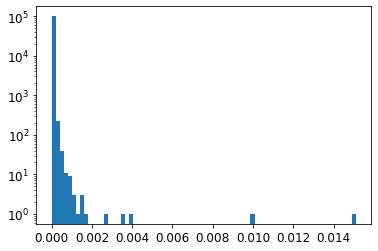

ESS: 2192.03
sampling efficiency: 2.19%


In [20]:
plt.hist(np.exp(logw), bins=75)
plt.yscale('log')
plt.show()

ess = np.exp(2*np.logaddexp.reduce(logw)-np.logaddexp.reduce(2*logw))
print(f'ESS: {ess:g}')
print(f'sampling efficiency: {ess/len(logw):.2%}')

In [21]:
# sorted_index = np.argsort(logw)
# logw = logw[sorted_index][:-10]
# mapped_data = mapped_data[sorted_index][:-10]

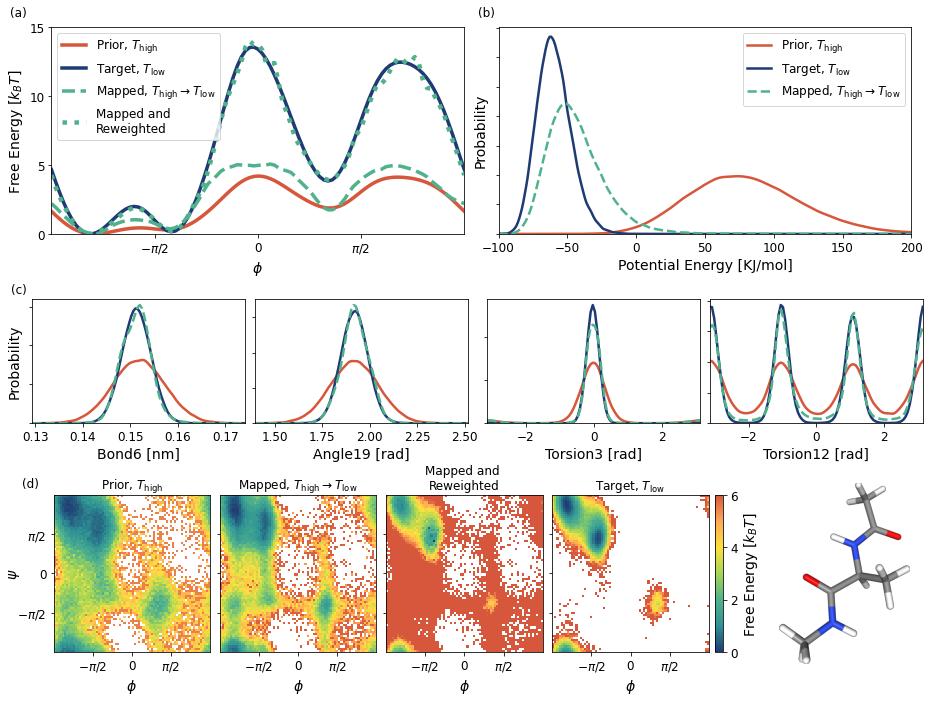

In [27]:
labels = ['Prior, $T_{\mathrm{high}}$', r'Mapped, $T_{\mathrm{high}} \rightarrow T_{\mathrm{low}}$', 'Mapped and Reweighted', 'Target, $T_{\mathrm{low}}$']
lw = 2.5
n_marginals = 4

fig = plt.figure(figsize=(2*6.4, 2*4.8), layout="constrained")
sizes = np.array([6, 4, 5]) #manually handle proportions
gs = fig.add_gridspec(sizes.sum(), 1, hspace=0.1)
gs_top = gs[:sizes[0]].subgridspec(1, 2)
gs_middle = gs[sizes[0]:-sizes[-1]].subgridspec(1, n_marginals)
gs_bottom = gs[-sizes[-1]:].subgridspec(1, 5)

#top row
axs = gs_top.subplots(sharex=False, sharey=False)

# phi FES
ax = axs[0]
ax.text(-0.1, 1.05, '(a)', transform=ax.transAxes, fontdict={'size': 12})

lw2 = lw + 1
ax.plot(fes_grid, prior_fes, c='fessa6', lw=lw2, label=labels[0])
ax.plot(fes_grid, target_fes, c='fessa0', lw=lw2, label=labels[-1])
ax.plot(fes_grid, mapped_fes, c='fessa2', lw=lw2, ls='--', label=labels[1])
my_str = labels[2]
labels[2] = my_str[:my_str.index('Rew')] + '\n' + my_str[my_str.index('Rew'):]
ax.plot(fes_grid, reweight_fes, c='fessa2', lw=lw2+1, ls=':', label=labels[2])

ax.set_xlim(-np.pi, np.pi)
ax.set_xticks(*ticks)
ax.set_xlabel('$\phi$')
ax.set_ylim(0, 15)
ax.set_yticks(np.arange(0,20,5))
ax.set_ylabel('Free Energy [$k_BT$]')
ax.legend()


# energies
ax = axs[1]
ax.text(-0.05, 1.05, '(b)', transform=ax.transAxes, fontdict={'size': 12})

ax.plot(ener_grid, prior_ener_fes, color=f'fessa6', label=labels[0], lw=lw)
ax.plot(ener_grid, target_ener_fes, color=f'fessa0', label=labels[-1], lw=lw)
ax.plot(ener_grid, mapped_ener_fes, color=f'fessa2', label=labels[1], lw=lw, ls='--')

ax.set_xlim(ener_grid[0], ener_grid[-1])
ax.set_ylim(0, None)
ax.set_xlabel('Potential Energy [KJ/mol]')
ax.set_ylabel('Probability')
ax.set_yticklabels([])
ax.legend()

#middle row
axs = gs_middle.subplots()#sharex=True, sharey=True)
axs[0].text(-0.1, 1.05, '(c)', transform=axs[0].transAxes, fontdict={'size': 12})

print('1...', end='\r')
plot_marginals(axs[0], 0, 6)
axs[0].set_ylabel('Probability')
# axs[0].legend()
print('2...', end='\r')
plot_marginals(axs[1], 1, 19)
print('3...', end='\r')
plot_marginals(axs[2], 2, 3)
print('4...', end='\r')
if n_marginals == 4:
    plot_marginals(axs[3], 2, 12)
elif n_marginals == 5:
    plot_marginals(axs[3], 2, 7)
    print('5...', end='\r')
    plot_marginals(axs[4], 2, 12)
else:
    raise ValueError(f'Wrong value for n_marginals: {n_marginals}')
print('             ', end='\r')

#bottom row
axs = gs_bottom.subplots()#sharex=True, sharey=True)
axs[0].text(-0.2, 1.05, '(d)', transform=axs[0].transAxes, fontdict={'size': 12})

ax = axs[0]
ax.set_title(labels[0])
plot_rama(ax, *get_phi_psi(prior_data), no_y=False)

ax = axs[1]
ax.set_title(labels[1])
plot_rama(ax, *get_phi_psi(mapped_data), no_y=True)

ax = axs[2]
ax.set_title(labels[2])
plot_rama(ax, *get_phi_psi(mapped_data), w=np.exp(logw), no_y=True)

ax = axs[3]
ax.set_title(labels[3])
ct = plot_rama(ax, *get_phi_psi(target_data), no_y=True)

cb = plt.colorbar(ct, ax=axs[:4], ticks=np.arange(0,7,2), pad=0.01, fraction=0.012)
cb.set_label('Free Energy [$k_BT$]')

ax = axs[4]
plt.imshow(plt.imread('ala2.png')) #terrible resolution!
ax.axis('off')

# fig.suptitle('Alanine Dipeptide')
plt.savefig('Ala2-all.pdf', bbox_inches='tight')
plt.show()

In [17]:
raise SystemError('Stop here')

SystemError: Stop here

## Supplementary information

In [ ]:
it = np.arange(len(reporter)) / (len(reporter)-1) * (len(test_reporter)-1)
plt.plot(it, reporter, label='training')
plt.plot(test_reporter, '--o', label='testing')
if DF != 0:
    plt.axhline(DF, c='red', ls='dotted', label='$\Delta F$')
plt.xlim(0, it[-1])
plt.ylabel('Loss [$k_\mathrm{B}T$]')
plt.xlabel('Epochs')
plt.xticks(np.arange(4))
plt.legend()
plt.savefig('Ala2-training.pdf', bbox_inches='tight')
plt.show()

## TOC graphic

In [ ]:
system_name = 'AlanineDipeptideImplicit'
lowT = 100
highT = 1000

mapped_data = np.load(f'../TREX/AlanineDipeptideImplicit-trajMapped.npz')['data']
model = bgmol.system_by_name(system_name)
model.reinitialize_energy_model(temperature=300)
mapped_ene = model.energy(torch.as_tensor(mapped_data).view(len(mapped_data),-1)).view(-1).cpu().numpy() * (kB*300)

In [ ]:
s = 1.7
fig = plt.figure(figsize=(s*3.25, s*1.75))#, layout="constrained")
gs = fig.add_gridspec(2, 2, wspace=0, hspace=0)
axs = gs.subplots()

ax = axs[0,0]
lw = 2.5
ene_lim = [-170, 80]
temperatures = [round(t) for t in np.geomspace(100, 1000, 6)]
filename = f'../BG_HREX/ene-{system_name}-T%d.npy'
# temperatures = np.geomspace(100, 1000, 6)
i = 6
for j,t in enumerate(reversed(temperatures)):
    if t == highT:
        label_t = '$T_{\mathrm{high}}$'
        ls = '-'
    elif t == lowT:
        label_t = '$T_{\mathrm{low}}$'
        ls = '-'
    else:
        label_t = f'$T_{j}$'
        ls = '--'
    ene_t = np.load(filename%t).reshape(-1) * (kB*t)
    grid = np.linspace(ene_t.min(), ene_t.max(), 100)
    ax.plot(grid, gaussian_kde(ene_t).pdf(grid), color=f'fessa{i}', label=label_t, ls=ls, lw=lw)
    # plt.hist(ene_t, bins='auto', density=True, histtype='step', label=f'T = {t} K', color=f'fessa{i}')
    if i == 2:
        i -= 1
    i -= 1
ax.set_xlim(ene_lim)
ax.set_ylim(0, None)
# ax.set_xlabel('Potential Energy')
ax.set_xticklabels([])
ax.set_yticklabels([])
legend_opt = {'borderpad': 0.3, 'labelspacing': 0.2, 'columnspacing': 0.3, 'handlelength': 1.5}
ax.legend(ncol=2, **legend_opt)
ax.set_ylabel('REX')
# ax.set_ylabel('Replica exchange')

ax = axs[1,0]

t = highT
ene_t = np.load(filename%t).reshape(-1) * (kB*t)
grid = np.linspace(ene_t.min(), ene_t.max(), 100)
ax.plot(grid, gaussian_kde(ene_t).pdf(grid), color=f'fessa6', label='$T_{\mathrm{high}}$', lw=lw)

grid = np.linspace(ene_lim[0], ene_lim[-1], 100)
ax.plot(grid, gaussian_kde(mapped_ene[mapped_ene<ene_lim[-1]]).pdf(grid), color=f'fessa2', label='Mapped $T_{\mathrm{high}}$', lw=lw, ls='-.')

t = lowT
ene_t = np.load(filename%t).reshape(-1) * (kB*t)
grid = np.linspace(ene_t.min(), ene_t.max(), 100)
ax.plot(grid, gaussian_kde(ene_t).pdf(grid), color=f'fessa0', label='$T_{\mathrm{low}}$', lw=lw)

ax.set_xlim(ene_lim)
ax.set_ylim(0, None)
ax.set_xlabel('Potential Energy')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.legend(**legend_opt)
ax.set_ylabel('LREX')

ax = axs[0,1]
ii = 0
for i in range(6):
    ls = '-' if i == 0 or i == 5 else '--'
    ax.axhline(i, c='fessa'+str(ii), lw=lw, ls=ls)
    ax.axvline(i, ls=':', color='k', lw=0.5)
    if ii == 1:
        ii += 1
    ii += 1

def exchange(ax, x, y, dy=1):
    dx = 0.1
    arrow_opt = {'length_includes_head': True, 'width': 0.001, 'head_width': 0.1, 'color': 'k', 'ls': ':'}
    ax.arrow(x-dx, y, 2*dx, -dy, **arrow_opt)
    ax.arrow(x-dx, y-dy, 2*dx, +dy, **arrow_opt)

exchange(ax, 1, 5)
exchange(ax, 1, 2)
exchange(ax, 2, 1)
exchange(ax, 2, 4)
exchange(ax, 3, 5)
exchange(ax, 3, 3)
exchange(ax, 4, 1)
exchange(ax, 4, 4)
exchange(ax, 5, 2)

ax.set_ylim(-0.5, 5.5)
# ax.set_yticks(np.arange(6), ['$p_{\mathrm{low}}$', '$p_1$', '$p_2$', '$p_3$', '$p_4$', '$p_{\mathrm{high}}$'])
ax.set_yticklabels([])
ax.set_xlim(0,5)
ax.set_xticks(np.arange(6), [])
# ax.set_xlabel('Simulation Time')


ax = axs[1,1]
ypos = .75
for i in range(1,6):
    ax.axvline(i, ls=':', color='k', lw=0.5)
    ax.arrow(i, 5, 0, -5+ypos, length_includes_head=True, color='fessa2', width=0.1, alpha=0.2, head_width=0.3)
    ax.arrow(i, 5, 0, -5+ypos, length_includes_head=True, color='fessa2', width=0.1, fill=False, head_width=0.3)
ax.axhline(0, c='fessa0', lw=lw)
ax.axhline(5, c='fessa6', lw=lw)
ax.axhline(ypos, c='fessa2', lw=lw, ls='-.')

exchange(ax, 1, ypos, ypos)
exchange(ax, 3, ypos, ypos)
exchange(ax, 4, ypos, ypos)

ax.set_ylim(-.5,5.5)
ax.set_xlim(0,5)
ax.set_xticks(np.arange(6), [])
# plt.yticks(np.arange(6), ['$p_{\mathrm{low}}$', '', '', '', '', '$p_{\mathrm{high}}$'])
# ax.set_yticks([0,ypos,5], ['$p_{\mathrm{low}}$', 'mapped', '$p_{\mathrm{high}}$'])
ax.set_yticks([0,ypos,5], [])
ax.set_xlabel('Simulation Time')


plt.savefig('GraphicTOC.pdf', bbox_inches='tight')

plt.show()